# Import the dataset

In [11]:
!pip install kagglehub

In [11]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gunavenkatdoddi/eye-diseases-classification")

print("Path to dataset files:", path)

/home/wandy/improc/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/wandy/.cache/kagglehub/datasets/gunavenkatdoddi/eye-diseases-classification/versions/1


# Visualize the dataset
Samples two random images per class

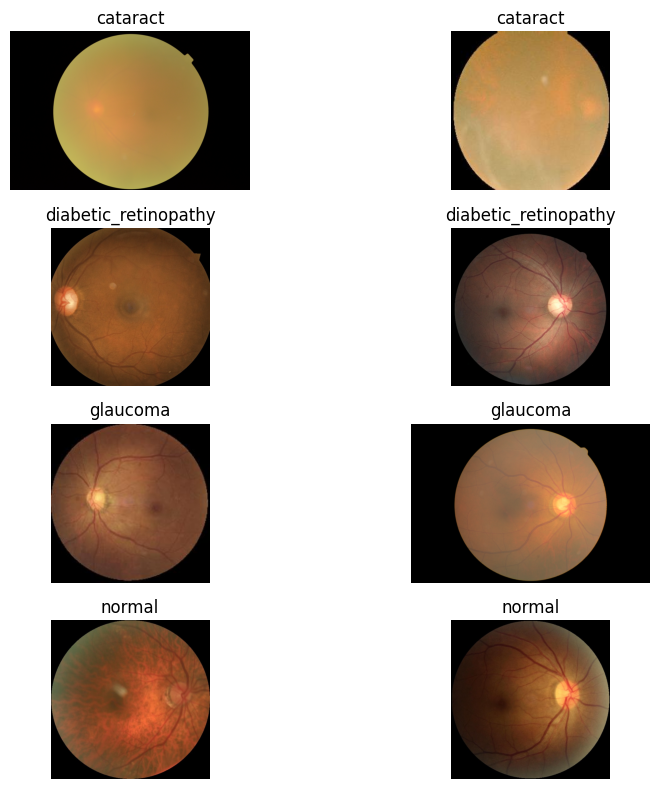

In [114]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Folder names (classes)
CLASSES = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"]

# Dictionary to store sampled file paths
sampled_images = {}

# Randomly pick 2 images per class
for cls in CLASSES:
    folder_path = os.path.join(path,"dataset", cls)
    all_images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    sampled = random.sample(all_images, 2)
    sampled_images[cls] = [os.path.join(folder_path, img) for img in sampled]

# Display the sampled images
plt.figure(figsize=(10, 8))

idx = 1
for cls, img_paths in sampled_images.items():
    for img_path in img_paths:
        plt.subplot(4, 2, idx)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(f"{cls}")
        plt.axis("off")
        idx += 1

plt.tight_layout()
plt.show()


# Dataset Preprocessing

In [13]:
import os
import random
from pathlib import Path
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import cv2   # if cv2 not available, install opencv-python


In [14]:
def load_image(path):
    img = Image.open(path)
    return img

def inspect_image(path):
    img = load_image(path)
    print("Path:", path)
    print("Mode:", img.mode)
    print("Size:", img.size)
    print("Dtype:", np.array(img).dtype)
    return img

# Example
# inspect_image("/path/to/some/image.jpg")


In [15]:
def resize_image_pil(img, target=(224,224), resample=Image.BILINEAR):
    return img.resize(target, resample=resample)


In [16]:
def resize_and_center_crop(img, target=(224,224)):
    w, h = img.size
    target_w, target_h = target
    scale = max(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)
    img_resized = img.resize((new_w, new_h), Image.LANCZOS)
    left = (new_w - target_w)//2
    top = (new_h - target_h)//2
    right = left + target_w
    bottom = top + target_h
    return img_resized.crop((left, top, right, bottom))


In [17]:
def ensure_rgb(img):
    if img.mode == "RGB":
        return img
    return img.convert("RGB")


In [18]:
def apply_clahe_mild(img_rgb, clip_limit=2.0, tile_grid_size=(8,8)):
    arr = np.array(img_rgb)
    r = arr[:, :, 0]
    g = arr[:, :, 1]
    b = arr[:, :, 2]

    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    g_clahe = clahe.apply(g)

    merged = np.stack([r, g_clahe, b], axis=-1).astype(np.uint8)
    return Image.fromarray(merged)


In [19]:
def denoise_cv2(img_pil, h=10):
    arr = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    denoised = cv2.fastNlMeansDenoisingColored(arr, None, h, h, 7, 21)
    denoised = cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB)
    return Image.fromarray(denoised)


In [20]:
def to_array_and_normalize(img_pil, scale_to_1=True):
    arr = np.array(img_pil).astype(np.float32)
    if scale_to_1:
        arr /= 255.0
    return arr  # shape (H, W, 3)


In [21]:
def preprocess_and_save_all(source_root, dest_root, classes, target=(224,224)):
    os.makedirs(dest_root, exist_ok=True)
    for cls in classes:
        src = Path(source_root) / cls
        dst_cls = Path(dest_root) / cls
        dst_cls.mkdir(parents=True, exist_ok=True)
        files = [f for f in src.iterdir() if f.suffix.lower() in (".jpg",".jpeg",".png")]
        for f in files:
            img = Image.open(str(f))
            img = ensure_rgb(img)
            img = resize_and_center_crop(img, target)
            img = apply_clahe_mild(img, clip_limit=1.5, tile_grid_size=(8,8))
            # optional denoise:
            # img = denoise_cv2(img, h=10)
            # normalization is done later by generator or saved as uint8
            save_path = dst_cls / f.name
            img.save(str(save_path), quality=95)
    print("Finished preprocessing and saved to", dest_root)

# Example usage:
# preprocess_and_save_all(SOURCE, "/home/wandy/improc/preprocessed_dataset", CLASSES, target=(224,224))


In [115]:
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

def plot_random_samples(preprocessed_root, classes, n_per_class=2):
    plt.figure(figsize=(4 * n_per_class, 4 * len(classes)))
    idx = 1

    for cls in classes:
        folder = Path(preprocessed_root) / cls
        files = [f for f in folder.iterdir() if f.suffix.lower() in (".jpg", ".jpeg", ".png")]

        if len(files) == 0:
            continue

        sampled = random.sample(files, min(n_per_class, len(files)))

        for fpath in sampled:
            img = Image.open(fpath)

            plt.subplot(len(classes), n_per_class, idx)
            plt.imshow(img)
            plt.title(f"Class: {cls}", fontsize=10)
            plt.axis("off")

            idx += 1

    plt.tight_layout()
    plt.show()


In [23]:
# Minimal flow (run sequentially):
SOURCE = "/home/wandy/.cache/kagglehub/datasets/gunavenkatdoddi/eye-diseases-classification/versions/1/dataset"
PREPROC = "/home/wandy/improc/UAS/preprocessed_dataset"
CLASSES = ["cataract","diabetic_retinopathy","glaucoma","normal"]
TARGET = (224,224)

preprocess_and_save_all(SOURCE, PREPROC, CLASSES, target=TARGET)
# After you visually verify, run your splitting code but point SOURCE to PREPROC


Finished preprocessing and saved to /home/wandy/improc/UAS/preprocessed_dataset


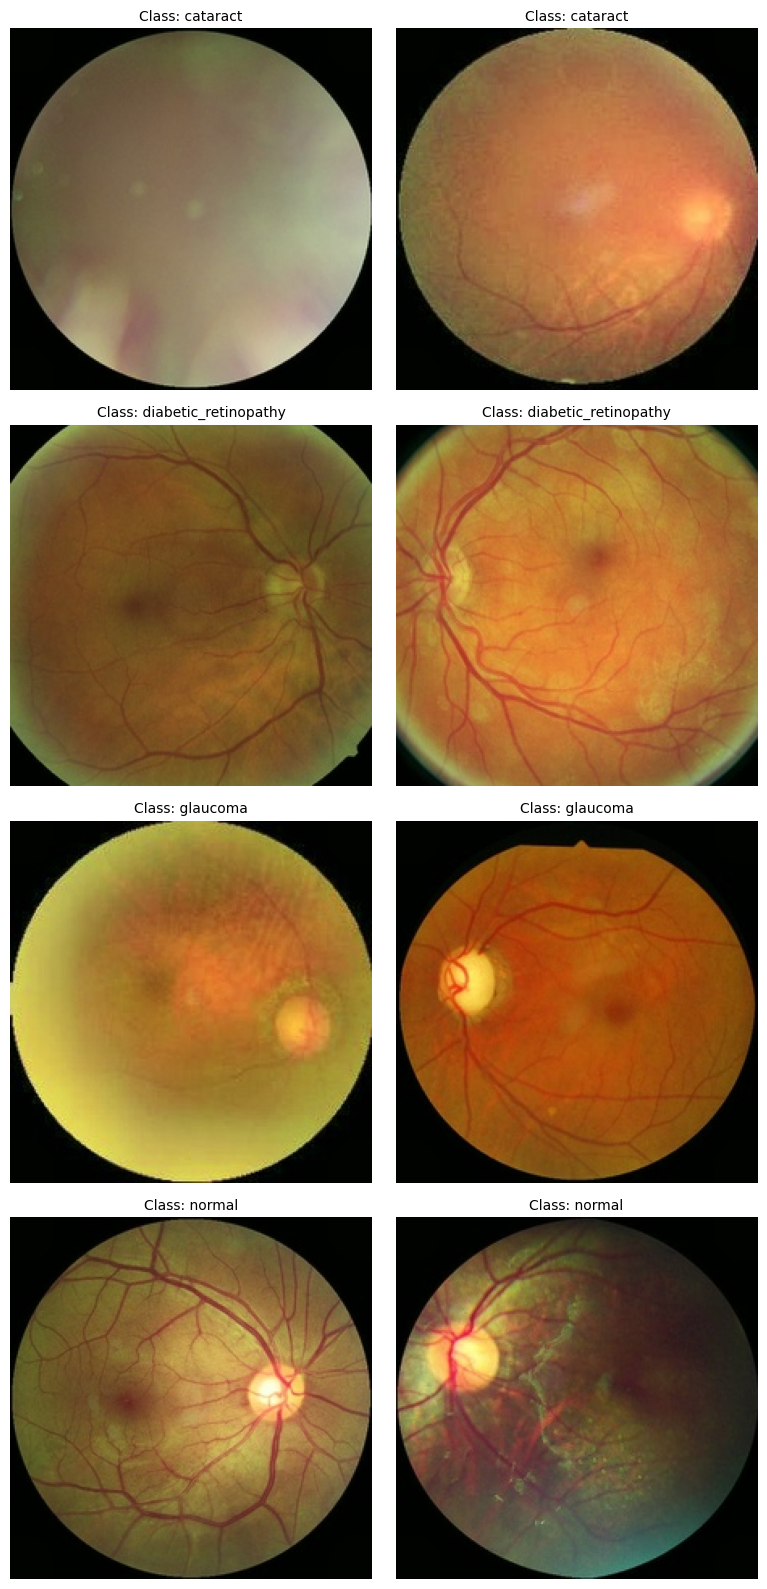

In [122]:
plot_random_samples(PREPROC, CLASSES, n_per_class=2)

# Splitting the Dataset
Data was split into train, test, and val with the composition 70% - 15% - 15%

In [47]:
import os
import shutil
import random

SOURCE = path + "/dataset"
DEST = "/home/wandy/improc/UAS/dataset_split"

CLASSES = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"]

# --- NEW PART: remove previous destination folder ---
if os.path.exists(DEST):
    shutil.rmtree(DEST)    # deletes the whole folder and contents

# recreate fresh destination structure
for split in ["train", "val", "test"]:
    for cls in CLASSES:
        os.makedirs(os.path.join(DEST, split, cls), exist_ok=True)

# --- dataset splitting ---
for cls in CLASSES:
    src_folder = os.path.join(SOURCE, cls)
    images = os.listdir(src_folder)
    random.shuffle(images)

    n = len(images)
    train_end = int(0.70 * n)
    val_end = int(0.85 * n)

    train_files = images[:train_end]
    val_files = images[train_end:val_end]
    test_files = images[val_end:]

    for f in train_files:
        shutil.copy(os.path.join(src_folder, f), os.path.join(DEST, "train", cls))

    for f in val_files:
        shutil.copy(os.path.join(src_folder, f), os.path.join(DEST, "val", cls))

    for f in test_files:
        shutil.copy(os.path.join(src_folder, f), os.path.join(DEST, "test", cls))

print("Dataset successfully split and overwritten!")


Dataset successfully split and overwritten!


In [49]:
DEST = "/home/wandy/improc/UAS/dataset_split"

splits = ["train", "val", "test"]

print("\nSplit Dataset Counts:")
split_totals = {"train": 0, "val": 0, "test": 0}

for split in splits:
    print(f"\n[{split.upper()}]")
    for cls in CLASSES:
        folder = os.path.join(DEST, split, cls)
        count = len([f for f in os.listdir(folder) if f.lower().endswith((".png", ".jpg", ".jpeg"))])
        split_totals[split] += count
        print(f"{cls}: {count}")

print("\nTOTALS:")
for split in splits:
    print(f"{split}: {split_totals[split]}")

print(f"\nGRAND TOTAL (train + val + test): {sum(split_totals.values())}")



Split Dataset Counts:

[TRAIN]
cataract: 726
diabetic_retinopathy: 768
glaucoma: 704
normal: 751

[VAL]
cataract: 156
diabetic_retinopathy: 165
glaucoma: 151
normal: 161

[TEST]
cataract: 156
diabetic_retinopathy: 165
glaucoma: 152
normal: 162

TOTALS:
train: 2949
val: 633
test: 635

GRAND TOTAL (train + val + test): 4217


# Import Libraries
Import all the libraries to ease development

In [50]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


In [51]:
import cv2

img = cv2.imread("/home/wandy/improc/UAS/dataset_split/train/diabetic_retinopathy/10035_right.jpeg")
height, width, _ = img.shape
print(f"Image Resolution: {width} x {height} pixels")

Image Resolution: 512 x 512 pixels


# Building the model
## Global Variables

In [52]:
DATASET_DIR = "/home/wandy/improc/UAS/dataset_split/"

IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 100


## Image augmentation

In [53]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


## Insert the image directory into the generator

In [54]:
train_generator = train_gen.flow_from_directory(
    DATASET_DIR + "train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse"
)

val_generator = val_test_gen.flow_from_directory(
    DATASET_DIR + "val",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse"
)


Found 2949 images belonging to 4 classes.
Found 633 images belonging to 4 classes.


In [55]:
test_generator = val_test_gen.flow_from_directory(
    os.path.join(DATASET_DIR, "test"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode="sparse"
)


Found 635 images belonging to 4 classes.


## Transfer learning using ResNet50
The base of the ResNet50 is not trained at first, only taking the base convolutional layers. 
Global Average Pooling is used to reduce the last convolutional layer into a singular vector.
Dropout is to randomly turn of 40% of the neurons, creating a robust model
Dense using softmax (the FC layer)

In [56]:
base = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base.trainable = False


In [57]:
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(4, activation="softmax")(x)

model = Model(inputs, outputs)


## Compile the current model

In [58]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Callbacks to tune the parameters mid-training

In [59]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]


## Unfreeze the base layers
To fine-tune the model, adapting the image features to the model

In [60]:
base.trainable = True

for layer in base.layers[:-50]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [61]:
from sklearn.utils import class_weight
import numpy as np

# Extract labels from train generator
labels = train_generator.classes
cw = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
cw = dict(enumerate(cw))


# Random Search

In [47]:
def build_model(unfreeze_mode="freeze_all", learning_rate=1e-4):
    base = ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # === Unfreezing strategies ===
    if unfreeze_mode == "freeze_all":
        base.trainable = False

    elif unfreeze_mode == "unfreeze_20":
        base.trainable = True
        for layer in base.layers[:-20]:
            layer.trainable = False

    elif unfreeze_mode == "unfreeze_50":
        base.trainable = True
        for layer in base.layers[:-50]:
            layer.trainable = False

    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(4, activation="softmax")(x)

    model = Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model


In [48]:
learning_rates = [1e-3, 1e-4, 1e-5]
early_stop_patience = [3, 5, 7]
lr_patience = [2, 3, 5]
unfreeze_modes = ["freeze_all", "unfreeze_20", "unfreeze_50"]

In [54]:
import numpy as np
import random
import tensorflow as tf

N_TRIALS = 15 

best_val_acc = 0.0
best_config = None
results = []

for trial in range(N_TRIALS):

    lr = random.choice(learning_rates)
    es_pat = random.choice(early_stop_patience)
    lr_pat = random.choice(lr_patience)
    unfreeze = random.choice(unfreeze_modes)

    print("\n==============================")
    print(f"TRIAL {trial+1}/{N_TRIALS}")
    print(f"LR={lr}, ES={es_pat}, LR_pat={lr_pat}, Unfreeze={unfreeze}")
    print("==============================")

    tf.keras.backend.clear_session()

    model = build_model(
        unfreeze_mode=unfreeze,
        learning_rate=lr
    )

    callbacks = [
        EarlyStopping(
            monitor="val_loss",
            patience=es_pat,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor="val_loss",
            patience=lr_pat,
            factor=0.2,
            min_lr=1e-6
        )
    ]

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=100,              # ⏱️ shorter for random search
        callbacks=callbacks,
        class_weight=cw,
        verbose=1
    )

    # ===== epoch information =====
    epochs_ran = len(history.history["loss"])
    best_epoch = np.argmax(history.history["val_accuracy"]) + 1
    max_val_acc = max(history.history["val_accuracy"])

    print(f"Epochs ran: {epochs_ran}")
    print(f"Best epoch: {best_epoch}")
    print(f"Best Val Acc: {max_val_acc:.4f}")

    results.append({
        "trial": trial + 1,
        "learning_rate": lr,
        "early_stop_patience": es_pat,
        "lr_patience": lr_pat,
        "unfreeze_mode": unfreeze,
        "epochs_ran": epochs_ran,
        "best_epoch": best_epoch,
        "best_val_accuracy": max_val_acc
    })

    if max_val_acc > best_val_acc:
        best_val_acc = max_val_acc
        best_config = results[-1]



TRIAL 1/15
LR=0.0001, ES=5, LR_pat=3, Unfreeze=unfreeze_20
Epoch 1/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 44s 188ms/step - accuracy: 0.7501 - loss: 0.6388 - val_accuracy: 0.7741 - val_loss: 0.6331 - learning_rate: 1.0000e-04
Epoch 2/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 28s 150ms/step - accuracy: 0.8522 - loss: 0.3972 - val_accuracy: 0.8483 - val_loss: 0.4491 - learning_rate: 1.0000e-04
Epoch 3/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 26s 142ms/step - accuracy: 0.8783 - loss: 0.3282 - val_accuracy: 0.8025 - val_loss: 0.5906 - learning_rate: 1.0000e-04
Epoch 4/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 144ms/step - accuracy: 0.8918 - loss: 0.2722 - val_accuracy: 0.8483 - val_loss: 0.4195 - learning_rate: 1.0000e-04
Epoch 5/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 144ms/step - accuracy: 0.9145 - loss: 0.2384 - val_accuracy: 0.8578 - val_loss: 0.4635 - learning_rate: 1.0000e-04
Epoch 6/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 29s 158ms/step - accuracy: 0.9240 - loss: 0.2036 - val_accuracy: 0.8736 - val_loss: 0.3485 - learni

In [55]:
print("\n🏆 BEST CONFIGURATION FOUND:")
for k, v in best_config.items():
    print(f"{k}: {v}")

print(f"\nBest Validation Accuracy: {best_val_acc:.4f}")



🏆 BEST CONFIGURATION FOUND:
trial: 12
learning_rate: 0.0001
early_stop_patience: 7
lr_patience: 5
unfreeze_mode: unfreeze_20
epochs_ran: 18
best_epoch: 18
best_val_accuracy: 0.9052132964134216

Best Validation Accuracy: 0.9052


In [4]:
experiments = [
  {
    "trial": 1,
    "hyperparams": { "lr": 0.0001, "early_stopping": 5, "lr_patience": 3, "unfreeze": "unfreeze_20" },
    "best": { "epoch": 8, "val_accuracy": 0.8957 },
    "epochs": [
        { "epoch": 1, "accuracy": 0.7501, "val_accuracy": 0.7741, "loss": 0.6388, "val_loss": 0.6331 },
        { "epoch": 2, "accuracy": 0.8522, "val_accuracy": 0.8483, "loss": 0.3972, "val_loss": 0.4491 },
        { "epoch": 3, "accuracy": 0.8783, "val_accuracy": 0.8025, "loss": 0.3282, "val_loss": 0.5906 },
        { "epoch": 4, "accuracy": 0.8918, "val_accuracy": 0.8483, "loss": 0.2722, "val_loss": 0.4195 },
        { "epoch": 5, "accuracy": 0.9145, "val_accuracy": 0.8578, "loss": 0.2384, "val_loss": 0.4635 },
        { "epoch": 6, "accuracy": 0.9240, "val_accuracy": 0.8736, "loss": 0.2036, "val_loss": 0.3485 },
        { "epoch": 7, "accuracy": 0.9285, "val_accuracy": 0.8847, "loss": 0.1980, "val_loss": 0.3685 },
        { "epoch": 8, "accuracy": 0.9356, "val_accuracy": 0.8957, "loss": 0.1666, "val_loss": 0.2942 },
        { "epoch": 9, "accuracy": 0.9471, "val_accuracy": 0.8641, "loss": 0.1465, "val_loss": 0.4804 },
        { "epoch": 10, "accuracy": 0.9468, "val_accuracy": 0.8926, "loss": 0.1471, "val_loss": 0.3382 },
        { "epoch": 11, "accuracy": 0.9502, "val_accuracy": 0.8799, "loss": 0.1445, "val_loss": 0.3536 },
        { "epoch": 12, "accuracy": 0.9712, "val_accuracy": 0.8926, "loss": 0.0838, "val_loss": 0.3344 },
        { "epoch": 13, "accuracy": 0.9736, "val_accuracy": 0.8957, "loss": 0.0751, "val_loss": 0.3620 }
    ]
  },

  {
    "trial": 2,
    "hyperparams": { "lr": 0.001, "early_stopping": 3, "lr_patience": 3, "unfreeze": "freeze_all" },
    "best": { "epoch": 5, "val_accuracy": 0.8215 },
    "epochs": [
      { "epoch": 1, "accuracy": 0.6663, "val_accuracy": 0.7646, "loss": 0.8251, "val_loss": 0.6080 },
      { "epoch": 2, "accuracy": 0.7647, "val_accuracy": 0.7820, "loss": 0.6009, "val_loss": 0.5903 },
      { "epoch": 3, "accuracy": 0.8013, "val_accuracy": 0.7725, "loss": 0.5295, "val_loss": 0.6103 },
      { "epoch": 4, "accuracy": 0.8128, "val_accuracy": 0.7725, "loss": 0.4935, "val_loss": 0.5854 },
      { "epoch": 5, "accuracy": 0.8274, "val_accuracy": 0.8215, "loss": 0.4522, "val_loss": 0.4588 },
      { "epoch": 6, "accuracy": 0.8362, "val_accuracy": 0.7520, "loss": 0.4247, "val_loss": 0.6126 },
      { "epoch": 7, "accuracy": 0.8264, "val_accuracy": 0.7488, "loss": 0.4457, "val_loss": 0.6816 },
      { "epoch": 8, "accuracy": 0.8257, "val_accuracy": 0.7930, "loss": 0.4589, "val_loss": 0.5436 }
    ]
  },

  {
    "trial": 3,
    "hyperparams": { "lr": 0.0001, "early_stopping": 7, "lr_patience": 5, "unfreeze": "unfreeze_20" },
    "best": { "epoch": 7, "val_accuracy": 0.8847 },
    "epochs": [
      { "epoch": 1, "accuracy": 0.7413, "val_accuracy": 0.8183, "loss": 0.6552, "val_loss": 0.5181 },
      { "epoch": 2, "accuracy": 0.8572, "val_accuracy": 0.7883, "loss": 0.4071, "val_loss": 0.6553 },
      { "epoch": 3, "accuracy": 0.8850, "val_accuracy": 0.8831, "loss": 0.3114, "val_loss": 0.3516 },
      { "epoch": 4, "accuracy": 0.8959, "val_accuracy": 0.8689, "loss": 0.2713, "val_loss": 0.3626 },
      { "epoch": 5, "accuracy": 0.9176, "val_accuracy": 0.8736, "loss": 0.2451, "val_loss": 0.3717 },
      { "epoch": 6, "accuracy": 0.9135, "val_accuracy": 0.8720, "loss": 0.2153, "val_loss": 0.3727 },
      { "epoch": 7, "accuracy": 0.9301, "val_accuracy": 0.8847, "loss": 0.1939, "val_loss": 0.3973 },
      { "epoch": 8, "accuracy": 0.9403, "val_accuracy": 0.8657, "loss": 0.1618, "val_loss": 0.5874 },
      { "epoch": 9, "accuracy": 0.9563, "val_accuracy": 0.8768, "loss": 0.1278, "val_loss": 0.4266 },
      { "epoch": 10, "accuracy": 0.9630, "val_accuracy": 0.8784, "loss": 0.1081, "val_loss": 0.4330 }
    ]
  },

  {
    "trial": 4,
    "hyperparams": { "lr": 0.0001, "early_stopping": 7, "lr_patience": 3, "unfreeze": "unfreeze_20" },
    "best": { "epoch": 11, "val_accuracy": 0.8973 },
    "epochs": [
      { "epoch": 1, "accuracy": 0.7382, "val_accuracy": 0.8483, "loss": 0.6708, "val_loss": 0.3968 },
      { "epoch": 2, "accuracy": 0.8427, "val_accuracy": 0.8578, "loss": 0.4058, "val_loss": 0.4032 },
      { "epoch": 3, "accuracy": 0.8796, "val_accuracy": 0.8483, "loss": 0.3265, "val_loss": 0.3832 },
      { "epoch": 4, "accuracy": 0.9000, "val_accuracy": 0.8863, "loss": 0.2742, "val_loss": 0.3228 },
      { "epoch": 5, "accuracy": 0.9064, "val_accuracy": 0.8799, "loss": 0.2506, "val_loss": 0.3783 },
      { "epoch": 6, "accuracy": 0.9230, "val_accuracy": 0.8531, "loss": 0.2055, "val_loss": 0.4939 },
      { "epoch": 7, "accuracy": 0.9230, "val_accuracy": 0.8278, "loss": 0.2053, "val_loss": 0.5745 },
      { "epoch": 8, "accuracy": 0.9495, "val_accuracy": 0.8847, "loss": 0.1462, "val_loss": 0.3847 },
      { "epoch": 9, "accuracy": 0.9596, "val_accuracy": 0.8910, "loss": 0.1258, "val_loss": 0.3822 },
      { "epoch": 10, "accuracy": 0.9634, "val_accuracy": 0.8926, "loss": 0.1011, "val_loss": 0.3776 },
      { "epoch": 11, "accuracy": 0.9661, "val_accuracy": 0.8973, "loss": 0.0931, "val_loss": 0.3553 }
    ]
  },

  {
    "trial": 5,
    "hyperparams": { "lr": 0.001, "early_stopping": 7, "lr_patience": 2, "unfreeze": "unfreeze_50" },
    "best": { "epoch": 10, "val_accuracy": 0.9005 },
    "epochs": [
      { "epoch": 1, "accuracy": 0.7569, "val_accuracy": 0.8057, "loss": 0.7280, "val_loss": 0.9039 },
      { "epoch": 2, "accuracy": 0.8423, "val_accuracy": 0.8404, "loss": 0.4336, "val_loss": 0.4535 },
      { "epoch": 3, "accuracy": 0.8681, "val_accuracy": 0.7678, "loss": 0.3623, "val_loss": 0.7192 },
      { "epoch": 4, "accuracy": 0.8840, "val_accuracy": 0.8578, "loss": 0.3201, "val_loss": 0.4060 },
      { "epoch": 5, "accuracy": 0.9061, "val_accuracy": 0.8657, "loss": 0.2567, "val_loss": 0.3828 },
      { "epoch": 6, "accuracy": 0.9027, "val_accuracy": 0.8657, "loss": 0.2509, "val_loss": 0.4369 },
      { "epoch": 7, "accuracy": 0.9173, "val_accuracy": 0.8989, "loss": 0.2203, "val_loss": 0.2894 },
      { "epoch": 8, "accuracy": 0.9193, "val_accuracy": 0.8768, "loss": 0.2339, "val_loss": 0.3314 },
      { "epoch": 9, "accuracy": 0.9264, "val_accuracy": 0.8562, "loss": 0.2085, "val_loss": 0.4464 },
      { "epoch": 10, "accuracy": 0.9488, "val_accuracy": 0.9005, "loss": 0.1535, "val_loss": 0.2547 },
      { "epoch": 11, "accuracy": 0.9539, "val_accuracy": 0.8957, "loss": 0.1333, "val_loss": 0.3019 },
      { "epoch": 12, "accuracy": 0.9559, "val_accuracy": 0.8910, "loss": 0.1158, "val_loss": 0.3148 },
      { "epoch": 13, "accuracy": 0.9624, "val_accuracy": 0.8957, "loss": 0.0996, "val_loss": 0.3020 },
      { "epoch": 14, "accuracy": 0.9620, "val_accuracy": 0.9005, "loss": 0.1053, "val_loss": 0.2861 },
      { "epoch": 15, "accuracy": 0.9654, "val_accuracy": 0.9005, "loss": 0.0946, "val_loss": 0.2879 },
      { "epoch": 16, "accuracy": 0.9685, "val_accuracy": 0.8989, "loss": 0.0829, "val_loss": 0.2831 },
      { "epoch": 17, "accuracy": 0.9722, "val_accuracy": 0.8989, "loss": 0.0819, "val_loss": 0.2825 }
    ]
  },
  {
    "trial": 6,
    "hyperparams": { "lr": 0.00001, "early_stopping": 5, "lr_patience": 3, "unfreeze": "unfreeze_50" },
    "best": { "epoch": 11, "val_accuracy": 0.8847 },
    "epochs": [
      { "epoch": 1, "accuracy": 0.5646, "val_accuracy": 0.7457, "loss": 1.0554, "val_loss": 0.6275 },
      { "epoch": 2, "accuracy": 0.7565, "val_accuracy": 0.7962, "loss": 0.6271, "val_loss": 0.4920 },
      { "epoch": 3, "accuracy": 0.8037, "val_accuracy": 0.8183, "loss": 0.5181, "val_loss": 0.4686 },
      { "epoch": 4, "accuracy": 0.8308, "val_accuracy": 0.8705, "loss": 0.4461, "val_loss": 0.3764 },
      { "epoch": 5, "accuracy": 0.8623, "val_accuracy": 0.8594, "loss": 0.3824, "val_loss": 0.3825 },
      { "epoch": 6, "accuracy": 0.8867, "val_accuracy": 0.8752, "loss": 0.3216, "val_loss": 0.3781 },
      { "epoch": 7, "accuracy": 0.8844, "val_accuracy": 0.8752, "loss": 0.3111, "val_loss": 0.3456 },
      { "epoch": 8, "accuracy": 0.8901, "val_accuracy": 0.8831, "loss": 0.3018, "val_loss": 0.3289 },
      { "epoch": 9, "accuracy": 0.9040, "val_accuracy": 0.8736, "loss": 0.2563, "val_loss": 0.3522 },
      { "epoch": 10, "accuracy": 0.9057, "val_accuracy": 0.8736, "loss": 0.2553, "val_loss": 0.3627 },
      { "epoch": 11, "accuracy": 0.9159, "val_accuracy": 0.8847, "loss": 0.2318, "val_loss": 0.3408 },
      { "epoch": 12, "accuracy": 0.9257, "val_accuracy": 0.8815, "loss": 0.2089, "val_loss": 0.3404 },
      { "epoch": 13, "accuracy": 0.9240, "val_accuracy": 0.8831, "loss": 0.2155, "val_loss": 0.3453 }
    ]
  },

  {
    "trial": 7,
    "hyperparams": { "lr": 0.0001, "early_stopping": 7, "lr_patience": 3, "unfreeze": "unfreeze_50" },
    "best": { "epoch": 9, "val_accuracy": 0.8878 },
    "epochs": [
      { "epoch": 1, "accuracy": 0.7755, "val_accuracy": 0.8515, "loss": 0.5828, "val_loss": 0.4397 },
      { "epoch": 2, "accuracy": 0.8566, "val_accuracy": 0.8705, "loss": 0.3852, "val_loss": 0.3259 },
      { "epoch": 3, "accuracy": 0.8928, "val_accuracy": 0.8705, "loss": 0.2845, "val_loss": 0.3588 },
      { "epoch": 4, "accuracy": 0.9098, "val_accuracy": 0.8547, "loss": 0.2470, "val_loss": 0.4863 },
      { "epoch": 5, "accuracy": 0.9213, "val_accuracy": 0.8689, "loss": 0.2146, "val_loss": 0.4084 },
      { "epoch": 6, "accuracy": 0.9430, "val_accuracy": 0.8847, "loss": 0.1474, "val_loss": 0.3485 },
      { "epoch": 7, "accuracy": 0.9576, "val_accuracy": 0.8863, "loss": 0.1154, "val_loss": 0.3365 },
      { "epoch": 8, "accuracy": 0.9610, "val_accuracy": 0.8863, "loss": 0.1092, "val_loss": 0.3311 },
      { "epoch": 9, "accuracy": 0.9674, "val_accuracy": 0.8878, "loss": 0.0993, "val_loss": 0.3311 }
    ]
  },

  {
    "trial": 8,
    "hyperparams": { "lr": 0.0001, "early_stopping": 3, "lr_patience": 2, "unfreeze": "unfreeze_20" },
    "best": { "epoch": 10, "val_accuracy": 0.8942 },
    "epochs": [
      { "epoch": 1, "accuracy": 0.7365, "val_accuracy": 0.8341, "loss": 0.6967, "val_loss": 0.4984 },
      { "epoch": 2, "accuracy": 0.8589, "val_accuracy": 0.8752, "loss": 0.3842, "val_loss": 0.3898 },
      { "epoch": 3, "accuracy": 0.8783, "val_accuracy": 0.8562, "loss": 0.3194, "val_loss": 0.4375 },
      { "epoch": 4, "accuracy": 0.9013, "val_accuracy": 0.8689, "loss": 0.2720, "val_loss": 0.4143 },
      { "epoch": 5, "accuracy": 0.9186, "val_accuracy": 0.8610, "loss": 0.2134, "val_loss": 0.3884 },
      { "epoch": 6, "accuracy": 0.9234, "val_accuracy": 0.8705, "loss": 0.2086, "val_loss": 0.3868 },
      { "epoch": 7, "accuracy": 0.9356, "val_accuracy": 0.8878, "loss": 0.1721, "val_loss": 0.3710 },
      { "epoch": 8, "accuracy": 0.9424, "val_accuracy": 0.8926, "loss": 0.1600, "val_loss": 0.3422 },
      { "epoch": 9, "accuracy": 0.9505, "val_accuracy": 0.8910, "loss": 0.1307, "val_loss": 0.3780 },
      { "epoch": 10, "accuracy": 0.9434, "val_accuracy": 0.8942, "loss": 0.1427, "val_loss": 0.3595 },
      { "epoch": 11, "accuracy": 0.9596, "val_accuracy": 0.8926, "loss": 0.1199, "val_loss": 0.3674 }
    ]
  },

  {
    "trial": 9,
    "hyperparams": { "lr": 0.0001, "early_stopping": 7, "lr_patience": 3, "unfreeze": "unfreeze_20" },
    "best": { "epoch": 10, "val_accuracy": 0.9005 },
    "epochs": [
      { "epoch": 1, "accuracy": 0.7406, "val_accuracy": 0.8104, "loss": 0.6692, "val_loss": 0.5605 },
      { "epoch": 2, "accuracy": 0.8559, "val_accuracy": 0.8468, "loss": 0.3994, "val_loss": 0.5047 },
      { "epoch": 3, "accuracy": 0.8756, "val_accuracy": 0.8468, "loss": 0.3198, "val_loss": 0.4427 },
      { "epoch": 4, "accuracy": 0.8932, "val_accuracy": 0.8167, "loss": 0.2762, "val_loss": 0.5349 },
      { "epoch": 5, "accuracy": 0.9149, "val_accuracy": 0.8689, "loss": 0.2213, "val_loss": 0.4335 },
      { "epoch": 6, "accuracy": 0.9193, "val_accuracy": 0.8626, "loss": 0.2166, "val_loss": 0.4135 },
      { "epoch": 7, "accuracy": 0.9234, "val_accuracy": 0.8468, "loss": 0.1987, "val_loss": 0.4881 },
      { "epoch": 8, "accuracy": 0.9342, "val_accuracy": 0.8752, "loss": 0.1723, "val_loss": 0.4278 },
      { "epoch": 9, "accuracy": 0.9407, "val_accuracy": 0.8752, "loss": 0.1627, "val_loss": 0.4248 },
      { "epoch": 10, "accuracy": 0.9522, "val_accuracy": 0.9005, "loss": 0.1277, "val_loss": 0.3282 },
      { "epoch": 11, "accuracy": 0.9654, "val_accuracy": 0.8910, "loss": 0.0991, "val_loss": 0.3452 },
      { "epoch": 12, "accuracy": 0.9698, "val_accuracy": 0.8926, "loss": 0.0880, "val_loss": 0.3426 },
      { "epoch": 13, "accuracy": 0.9708, "val_accuracy": 0.8942, "loss": 0.0850, "val_loss": 0.3183 },
      { "epoch": 14, "accuracy": 0.9722, "val_accuracy": 0.8926, "loss": 0.0743, "val_loss": 0.3624 },
      { "epoch": 15, "accuracy": 0.9769, "val_accuracy": 0.8989, "loss": 0.0670, "val_loss": 0.3607 },
      { "epoch": 16, "accuracy": 0.9817, "val_accuracy": 0.8957, "loss": 0.0567, "val_loss": 0.3652 },
      { "epoch": 17, "accuracy": 0.9797, "val_accuracy": 0.8989, "loss": 0.0600, "val_loss": 0.3577 },
      { "epoch": 18, "accuracy": 0.9790, "val_accuracy": 0.8973, "loss": 0.0591, "val_loss": 0.3537 },
      { "epoch": 19, "accuracy": 0.9824, "val_accuracy": 0.8957, "loss": 0.0504, "val_loss": 0.3565 },
      { "epoch": 20, "accuracy": 0.9868, "val_accuracy": 0.8957, "loss": 0.0450, "val_loss": 0.3578 }
    ]
  },

  {
    "trial": 10,
    "hyperparams": { "lr": 0.00001, "early_stopping": 3, "lr_patience": 2, "unfreeze": "unfreeze_20" },
    "best": { "epoch": 9, "val_accuracy": 0.8468 },
    "epochs": [
      { "epoch": 1, "accuracy": 0.5097, "val_accuracy": 0.7093, "loss": 1.1332, "val_loss": 0.7094 },
      { "epoch": 2, "accuracy": 0.6904, "val_accuracy": 0.7551, "loss": 0.7618, "val_loss": 0.5813 },
      { "epoch": 3, "accuracy": 0.7514, "val_accuracy": 0.7709, "loss": 0.6360, "val_loss": 0.5458 },
      { "epoch": 4, "accuracy": 0.7843, "val_accuracy": 0.7852, "loss": 0.5630, "val_loss": 0.5126 },
      { "epoch": 5, "accuracy": 0.8101, "val_accuracy": 0.7820, "loss": 0.4849, "val_loss": 0.5642 },
      { "epoch": 6, "accuracy": 0.8301, "val_accuracy": 0.8183, "loss": 0.4557, "val_loss": 0.4982 },
      { "epoch": 7, "accuracy": 0.8528, "val_accuracy": 0.8136, "loss": 0.4040, "val_loss": 0.5091 },
      { "epoch": 8, "accuracy": 0.8505, "val_accuracy": 0.8341, "loss": 0.3933, "val_loss": 0.4819 },
      { "epoch": 9, "accuracy": 0.8627, "val_accuracy": 0.8468, "loss": 0.3666, "val_loss": 0.4572 },
      { "epoch": 10, "accuracy": 0.8800, "val_accuracy": 0.8373, "loss": 0.3314, "val_loss": 0.4993 },
      { "epoch": 11, "accuracy": 0.8793, "val_accuracy": 0.8373, "loss": 0.3196, "val_loss": 0.4886 },
      { "epoch": 12, "accuracy": 0.8783, "val_accuracy": 0.8420, "loss": 0.3244, "val_loss": 0.4634 }
    ]
  },
  {
    "trial": 11,
    "hyperparams": { "lr": 0.00001, "early_stopping": 7, "lr_patience": 5, "unfreeze": "unfreeze_20" },
    "best": { "epoch": 16, "val_accuracy": 0.8752 },
    "epochs": [
      { "epoch": 1, "accuracy": 0.4998, "val_accuracy": 0.7235, "loss": 1.2558, "val_loss": 0.6549 },
      { "epoch": 2, "accuracy": 0.7219, "val_accuracy": 0.7599, "loss": 0.7235, "val_loss": 0.5488 },
      { "epoch": 3, "accuracy": 0.7565, "val_accuracy": 0.7757, "loss": 0.6375, "val_loss": 0.5347 },
      { "epoch": 4, "accuracy": 0.7959, "val_accuracy": 0.8057, "loss": 0.5436, "val_loss": 0.4970 },
      { "epoch": 5, "accuracy": 0.8118, "val_accuracy": 0.8136, "loss": 0.4951, "val_loss": 0.4824 },
      { "epoch": 6, "accuracy": 0.8298, "val_accuracy": 0.8215, "loss": 0.4543, "val_loss": 0.4665 },
      { "epoch": 7, "accuracy": 0.8427, "val_accuracy": 0.8215, "loss": 0.4128, "val_loss": 0.4882 },
      { "epoch": 8, "accuracy": 0.8576, "val_accuracy": 0.8325, "loss": 0.3853, "val_loss": 0.4777 },
      { "epoch": 9, "accuracy": 0.8654, "val_accuracy": 0.8341, "loss": 0.3596, "val_loss": 0.4658 },
      { "epoch": 10, "accuracy": 0.8766, "val_accuracy": 0.8389, "loss": 0.3353, "val_loss": 0.4726 },
      { "epoch": 11, "accuracy": 0.8911, "val_accuracy": 0.8373, "loss": 0.3136, "val_loss": 0.4810 },
      { "epoch": 12, "accuracy": 0.8928, "val_accuracy": 0.8499, "loss": 0.2989, "val_loss": 0.4500 },
      { "epoch": 13, "accuracy": 0.9017, "val_accuracy": 0.8499, "loss": 0.2737, "val_loss": 0.4556 },
      { "epoch": 14, "accuracy": 0.9054, "val_accuracy": 0.8515, "loss": 0.2627, "val_loss": 0.4366 },
      { "epoch": 15, "accuracy": 0.9159, "val_accuracy": 0.8626, "loss": 0.2348, "val_loss": 0.4383 },
      { "epoch": 16, "accuracy": 0.9132, "val_accuracy": 0.8752, "loss": 0.2405, "val_loss": 0.3723 },
      { "epoch": 17, "accuracy": 0.9159, "val_accuracy": 0.8657, "loss": 0.2302, "val_loss": 0.4346 },
      { "epoch": 18, "accuracy": 0.9281, "val_accuracy": 0.8673, "loss": 0.1978, "val_loss": 0.4289 },
      { "epoch": 19, "accuracy": 0.9223, "val_accuracy": 0.8752, "loss": 0.2096, "val_loss": 0.3794 },
      { "epoch": 20, "accuracy": 0.9285, "val_accuracy": 0.8673, "loss": 0.1879, "val_loss": 0.4154 },
      { "epoch": 21, "accuracy": 0.9322, "val_accuracy": 0.8720, "loss": 0.1839, "val_loss": 0.4484 },
      { "epoch": 22, "accuracy": 0.9434, "val_accuracy": 0.8705, "loss": 0.1576, "val_loss": 0.4278 },
      { "epoch": 23, "accuracy": 0.9373, "val_accuracy": 0.8752, "loss": 0.1695, "val_loss": 0.4255 }
    ]
  },

  {
    "trial": 12,
    "hyperparams": { "lr": 0.0001, "early_stopping": 7, "lr_patience": 5, "unfreeze": "unfreeze_20" },
    "best": { "epoch": 18, "val_accuracy": 0.9052 },
    "epochs": [
      { "epoch": 1, "accuracy": 0.7406, "val_accuracy": 0.7441, "loss": 0.6708, "val_loss": 0.6833 },
      { "epoch": 2, "accuracy": 0.8569, "val_accuracy": 0.8515, "loss": 0.3907, "val_loss": 0.3953 },
      { "epoch": 3, "accuracy": 0.8718, "val_accuracy": 0.8657, "loss": 0.3212, "val_loss": 0.4845 },
      { "epoch": 4, "accuracy": 0.9030, "val_accuracy": 0.8768, "loss": 0.2676, "val_loss": 0.3564 },
      { "epoch": 5, "accuracy": 0.8949, "val_accuracy": 0.8547, "loss": 0.2627, "val_loss": 0.4227 },
      { "epoch": 6, "accuracy": 0.9237, "val_accuracy": 0.8689, "loss": 0.2044, "val_loss": 0.3845 },
      { "epoch": 7, "accuracy": 0.9298, "val_accuracy": 0.8863, "loss": 0.1883, "val_loss": 0.3901 },
      { "epoch": 8, "accuracy": 0.9352, "val_accuracy": 0.8784, "loss": 0.1749, "val_loss": 0.3553 },
      { "epoch": 9, "accuracy": 0.9390, "val_accuracy": 0.8673, "loss": 0.1674, "val_loss": 0.3918 },
      { "epoch": 10, "accuracy": 0.9539, "val_accuracy": 0.8736, "loss": 0.1340, "val_loss": 0.4119 },
      { "epoch": 11, "accuracy": 0.9532, "val_accuracy": 0.9005, "loss": 0.1289, "val_loss": 0.3344 },
      { "epoch": 12, "accuracy": 0.9552, "val_accuracy": 0.8752, "loss": 0.1287, "val_loss": 0.3891 },
      { "epoch": 13, "accuracy": 0.9464, "val_accuracy": 0.8720, "loss": 0.1362, "val_loss": 0.5015 },
      { "epoch": 14, "accuracy": 0.9596, "val_accuracy": 0.8799, "loss": 0.1066, "val_loss": 0.5912 },
      { "epoch": 15, "accuracy": 0.9634, "val_accuracy": 0.8847, "loss": 0.1116, "val_loss": 0.4942 },
      { "epoch": 16, "accuracy": 0.9691, "val_accuracy": 0.8436, "loss": 0.0888, "val_loss": 0.6039 },
      { "epoch": 17, "accuracy": 0.9698, "val_accuracy": 0.8942, "loss": 0.0831, "val_loss": 0.3820 },
      { "epoch": 18, "accuracy": 0.9854, "val_accuracy": 0.9052, "loss": 0.0496, "val_loss": 0.3794 }
    ]
  },

  {
    "trial": 13,
    "hyperparams": { "lr": 0.001, "early_stopping": 3, "lr_patience": 2, "unfreeze": "unfreeze_50" },
    "best": { "epoch": 6, "val_accuracy": 0.9036 },
    "epochs": [
      { "epoch": 1, "accuracy": 0.7660, "val_accuracy": 0.7899, "loss": 0.6854, "val_loss": 0.9403 },
      { "epoch": 2, "accuracy": 0.8532, "val_accuracy": 0.6493, "loss": 0.3981, "val_loss": 1.3441 },
      { "epoch": 3, "accuracy": 0.8728, "val_accuracy": 0.8926, "loss": 0.3421, "val_loss": 0.2792 },
      { "epoch": 4, "accuracy": 0.8918, "val_accuracy": 0.8594, "loss": 0.3108, "val_loss": 0.4117 },
      { "epoch": 5, "accuracy": 0.9027, "val_accuracy": 0.8910, "loss": 0.2706, "val_loss": 0.2880 },
      { "epoch": 6, "accuracy": 0.9230, "val_accuracy": 0.9036, "loss": 0.2013, "val_loss": 0.2670 },
      { "epoch": 7, "accuracy": 0.9349, "val_accuracy": 0.8863, "loss": 0.1709, "val_loss": 0.3014 },
      { "epoch": 8, "accuracy": 0.9437, "val_accuracy": 0.8957, "loss": 0.1592, "val_loss": 0.3146 },
      { "epoch": 9, "accuracy": 0.9522, "val_accuracy": 0.9036, "loss": 0.1276, "val_loss": 0.2743 }
    ]
  },

  {
    "trial": 14,
    "hyperparams": { "lr": 0.0001, "early_stopping": 7, "lr_patience": 3, "unfreeze": "unfreeze_20" },
    "best": { "epoch": 12, "val_accuracy": 0.9005 },
    "epochs": [
      { "epoch": 1, "accuracy": 0.7548, "val_accuracy": 0.7820, "loss": 0.6434, "val_loss": 0.6511 },
      { "epoch": 2, "accuracy": 0.8620, "val_accuracy": 0.8578, "loss": 0.3740, "val_loss": 0.3978 },
      { "epoch": 3, "accuracy": 0.8735, "val_accuracy": 0.8547, "loss": 0.3341, "val_loss": 0.3804 },
      { "epoch": 4, "accuracy": 0.9020, "val_accuracy": 0.8578, "loss": 0.2617, "val_loss": 0.4475 },
      { "epoch": 5, "accuracy": 0.9081, "val_accuracy": 0.8626, "loss": 0.2465, "val_loss": 0.3815 },
      { "epoch": 6, "accuracy": 0.9149, "val_accuracy": 0.8436, "loss": 0.2165, "val_loss": 0.4446 },
      { "epoch": 7, "accuracy": 0.9413, "val_accuracy": 0.8863, "loss": 0.1594, "val_loss": 0.3166 },
      { "epoch": 8, "accuracy": 0.9491, "val_accuracy": 0.8799, "loss": 0.1373, "val_loss": 0.3196 },
      { "epoch": 9, "accuracy": 0.9559, "val_accuracy": 0.8831, "loss": 0.1208, "val_loss": 0.3486 },
      { "epoch": 10, "accuracy": 0.9607, "val_accuracy": 0.8894, "loss": 0.1208, "val_loss": 0.3150 },
      { "epoch": 11, "accuracy": 0.9651, "val_accuracy": 0.8689, "loss": 0.0991, "val_loss": 0.4109 },
      { "epoch": 12, "accuracy": 0.9678, "val_accuracy": 0.9005, "loss": 0.0934, "val_loss": 0.3144 },
      { "epoch": 13, "accuracy": 0.9644, "val_accuracy": 0.8641, "loss": 0.0982, "val_loss": 0.3990 },
      { "epoch": 14, "accuracy": 0.9705, "val_accuracy": 0.8847, "loss": 0.0822, "val_loss": 0.3750 },
      { "epoch": 15, "accuracy": 0.9759, "val_accuracy": 0.8847, "loss": 0.0720, "val_loss": 0.3841 },
      { "epoch": 16, "accuracy": 0.9742, "val_accuracy": 0.8831, "loss": 0.0684, "val_loss": 0.3760 },
      { "epoch": 17, "accuracy": 0.9780, "val_accuracy": 0.8831, "loss": 0.0652, "val_loss": 0.3679 },
      { "epoch": 18, "accuracy": 0.9783, "val_accuracy": 0.8910, "loss": 0.0631, "val_loss": 0.3630 },
      { "epoch": 19, "accuracy": 0.9844, "val_accuracy": 0.8910, "loss": 0.0559, "val_loss": 0.3663 }
    ]
  },

  {
    "trial": 15,
    "hyperparams": { "lr": 0.0001, "early_stopping": 5, "lr_patience": 2, "unfreeze": "freeze_all" },
    "best": { "epoch": 14, "val_accuracy": 0.7915 },
    "epochs": [
      { "epoch": 1, "accuracy": 0.4028, "val_accuracy": 0.6588, "loss": 1.4039, "val_loss": 0.8650 },
      { "epoch": 2, "accuracy": 0.6043, "val_accuracy": 0.6856, "loss": 0.9800, "val_loss": 0.7383 },
      { "epoch": 3, "accuracy": 0.6579, "val_accuracy": 0.7283, "loss": 0.8436, "val_loss": 0.6651 },
      { "epoch": 4, "accuracy": 0.6887, "val_accuracy": 0.7235, "loss": 0.7541, "val_loss": 0.6518 },
      { "epoch": 5, "accuracy": 0.7233, "val_accuracy": 0.7362, "loss": 0.6988, "val_loss": 0.6136 },
      { "epoch": 6, "accuracy": 0.7403, "val_accuracy": 0.7393, "loss": 0.6662, "val_loss": 0.6109 },
      { "epoch": 7, "accuracy": 0.7379, "val_accuracy": 0.7520, "loss": 0.6510, "val_loss": 0.5904 },
      { "epoch": 8, "accuracy": 0.7565, "val_accuracy": 0.7488, "loss": 0.6117, "val_loss": 0.5861 },
      { "epoch": 9, "accuracy": 0.7636, "val_accuracy": 0.7536, "loss": 0.5821, "val_loss": 0.5892 },
      { "epoch": 10, "accuracy": 0.7674, "val_accuracy": 0.7788, "loss": 0.5801, "val_loss": 0.5489 },
      { "epoch": 11, "accuracy": 0.7735, "val_accuracy": 0.7662, "loss": 0.5638, "val_loss": 0.5576 },
      { "epoch": 12, "accuracy": 0.7738, "val_accuracy": 0.7773, "loss": 0.5716, "val_loss": 0.5426 },
      { "epoch": 13, "accuracy": 0.7894, "val_accuracy": 0.7883, "loss": 0.5323, "val_loss": 0.5251 },
      { "epoch": 14, "accuracy": 0.7908, "val_accuracy": 0.7915, "loss": 0.5294, "val_loss": 0.5211 },
      { "epoch": 15, "accuracy": 0.8013, "val_accuracy": 0.7852, "loss": 0.5199, "val_loss": 0.5327 },
      { "epoch": 16, "accuracy": 0.8023, "val_accuracy": 0.7915, "loss": 0.5076, "val_loss": 0.5266 },
      { "epoch": 17, "accuracy": 0.8026, "val_accuracy": 0.7852, "loss": 0.4916, "val_loss": 0.5360 },
      { "epoch": 18, "accuracy": 0.8111, "val_accuracy": 0.7899, "loss": 0.4898, "val_loss": 0.5255 },
      { "epoch": 19, "accuracy": 0.8043, "val_accuracy": 0.7883, "loss": 0.5049, "val_loss": 0.5259 }
    ]
  }
]


## Evaluation of Random Search


TRIAL 1
Final Train Acc : 0.9736
Final Val Acc   : 0.8957
Final Train Loss: 0.0751
Final Val Loss  : 0.3620


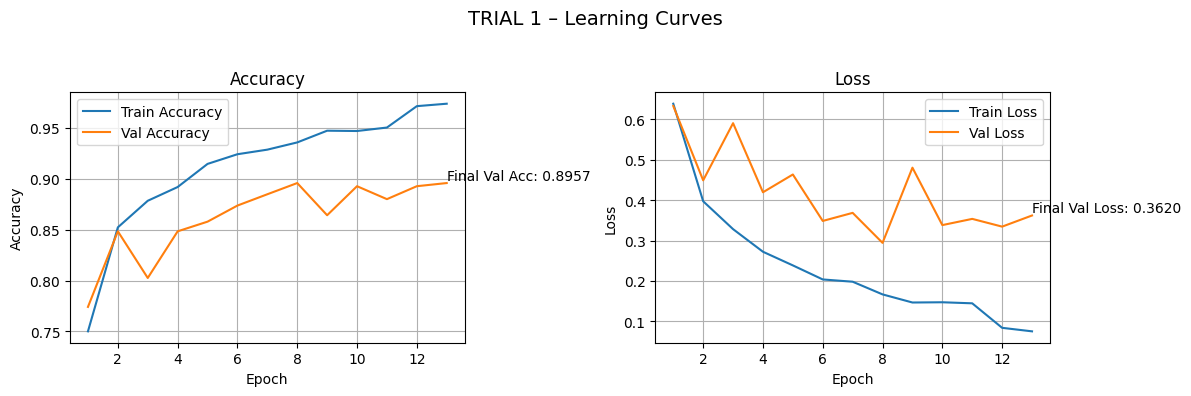


TRIAL 2
Final Train Acc : 0.8257
Final Val Acc   : 0.7930
Final Train Loss: 0.4589
Final Val Loss  : 0.5436


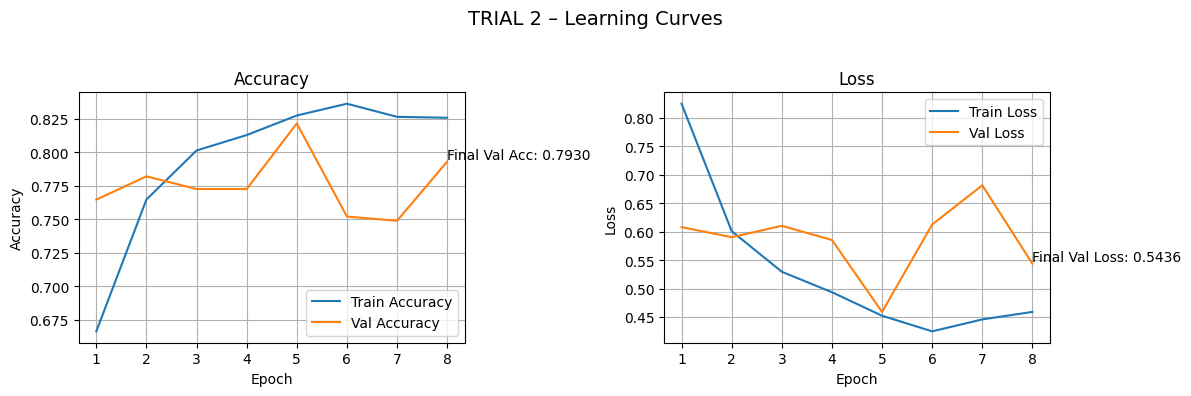


TRIAL 3
Final Train Acc : 0.9630
Final Val Acc   : 0.8784
Final Train Loss: 0.1081
Final Val Loss  : 0.4330


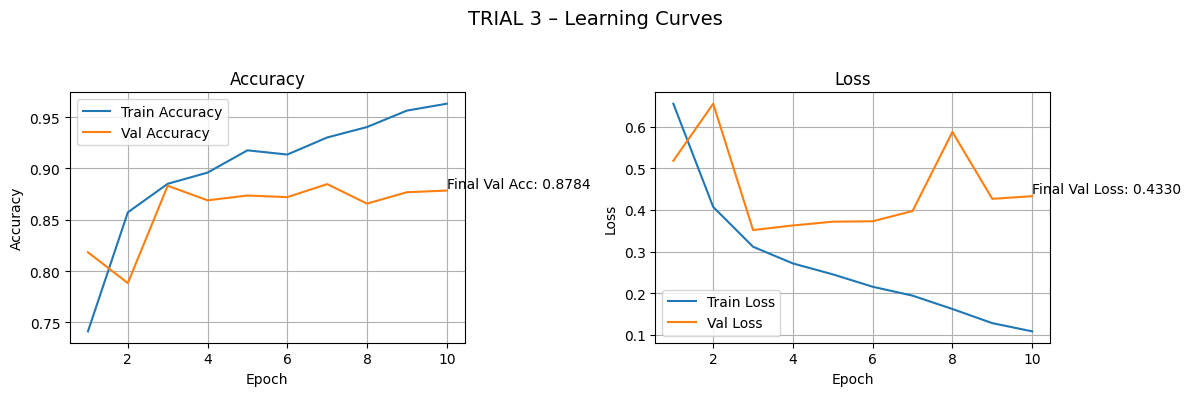


TRIAL 4
Final Train Acc : 0.9661
Final Val Acc   : 0.8973
Final Train Loss: 0.0931
Final Val Loss  : 0.3553


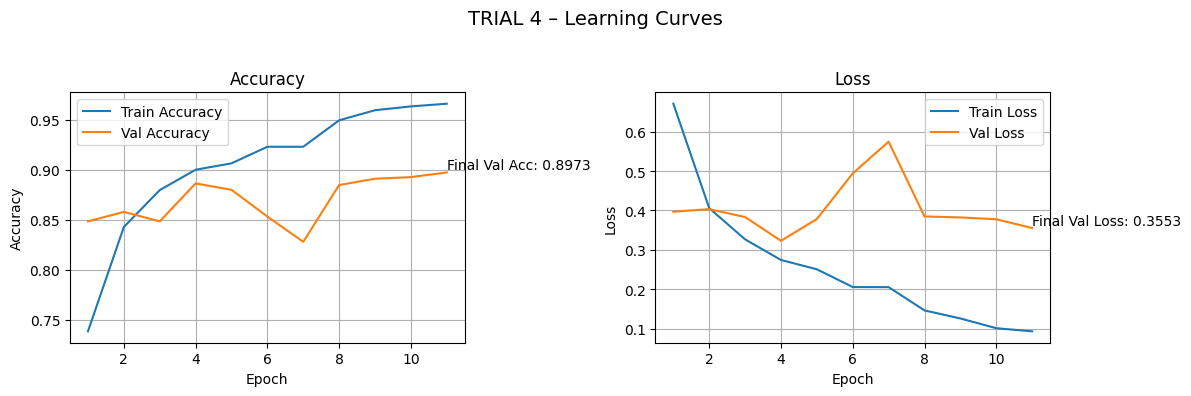


TRIAL 5
Final Train Acc : 0.9722
Final Val Acc   : 0.8989
Final Train Loss: 0.0819
Final Val Loss  : 0.2825


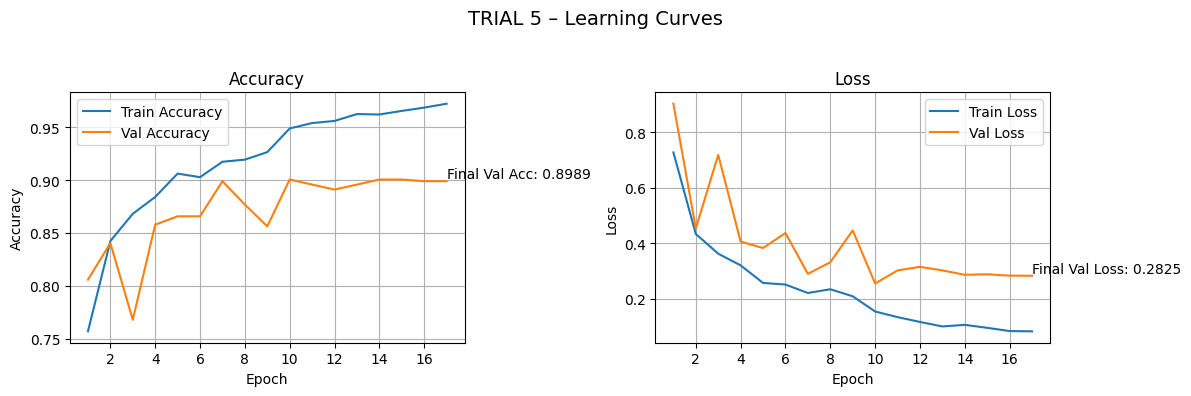


TRIAL 6
Final Train Acc : 0.9240
Final Val Acc   : 0.8831
Final Train Loss: 0.2155
Final Val Loss  : 0.3453


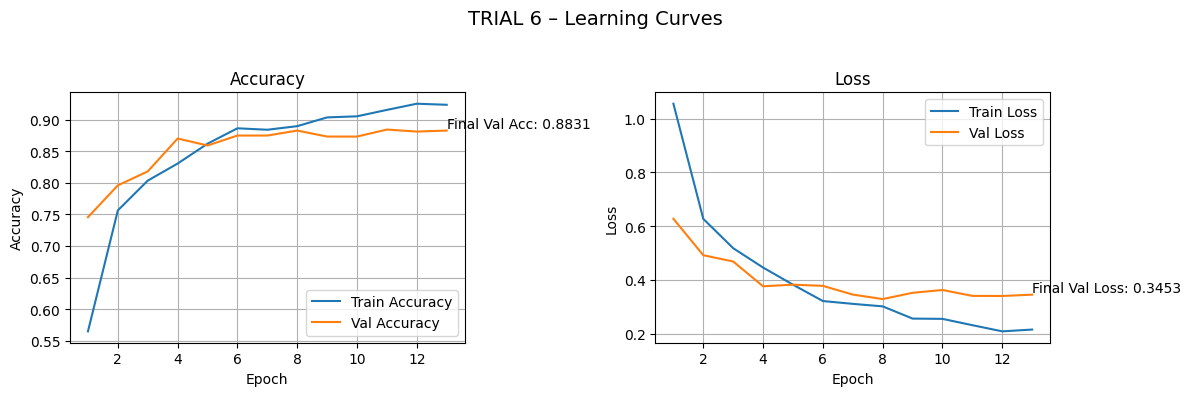


TRIAL 7
Final Train Acc : 0.9674
Final Val Acc   : 0.8878
Final Train Loss: 0.0993
Final Val Loss  : 0.3311


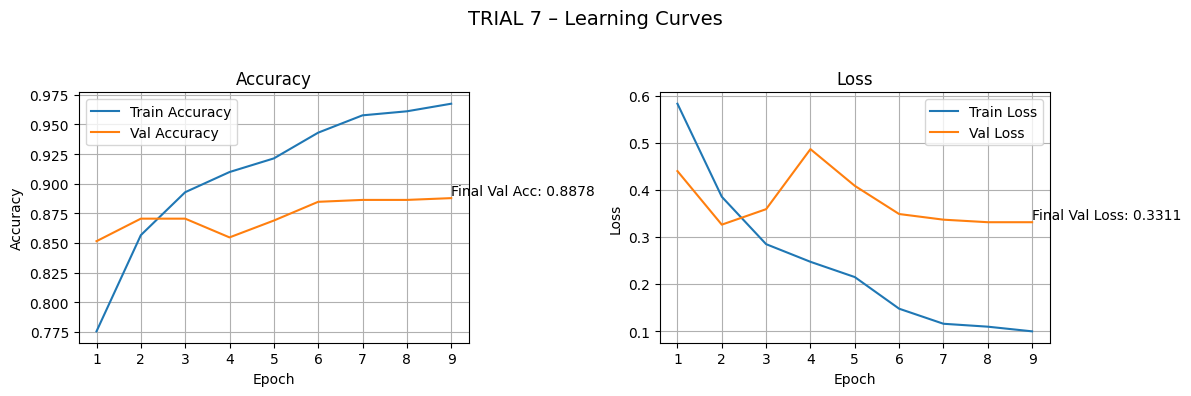


TRIAL 8
Final Train Acc : 0.9596
Final Val Acc   : 0.8926
Final Train Loss: 0.1199
Final Val Loss  : 0.3674


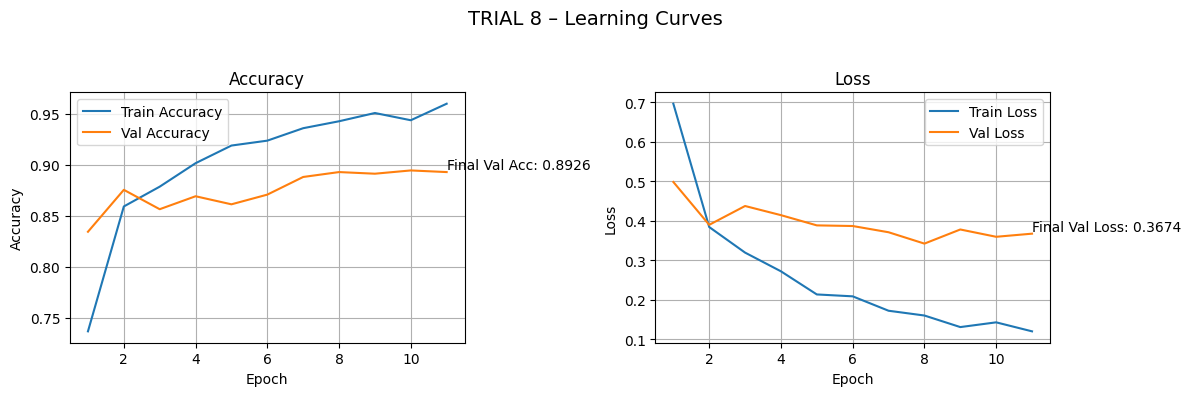


TRIAL 9
Final Train Acc : 0.9868
Final Val Acc   : 0.8957
Final Train Loss: 0.0450
Final Val Loss  : 0.3578


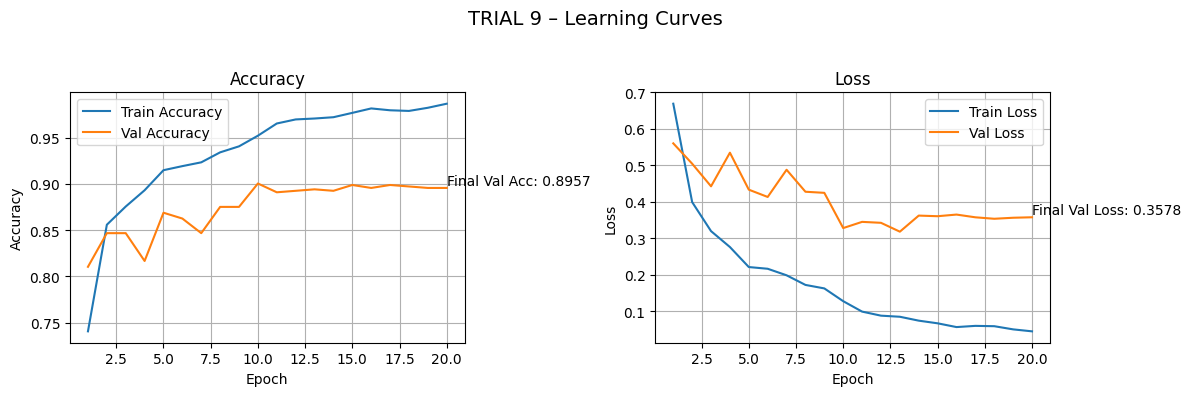


TRIAL 10
Final Train Acc : 0.8783
Final Val Acc   : 0.8420
Final Train Loss: 0.3244
Final Val Loss  : 0.4634


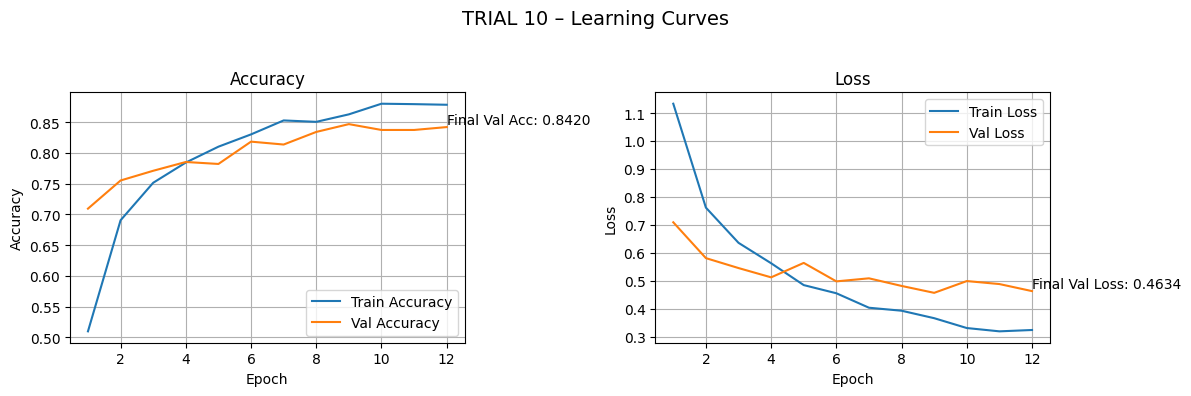


TRIAL 11
Final Train Acc : 0.9373
Final Val Acc   : 0.8752
Final Train Loss: 0.1695
Final Val Loss  : 0.4255


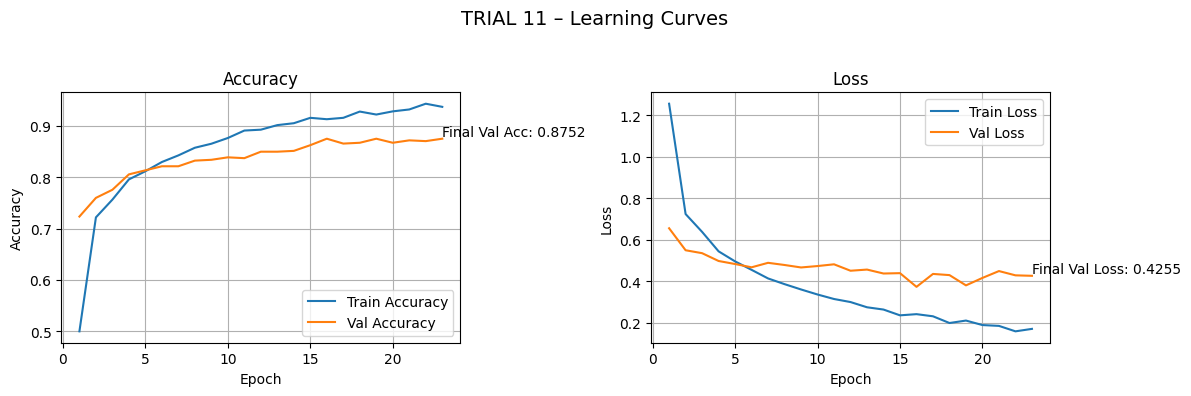


TRIAL 12
Final Train Acc : 0.9854
Final Val Acc   : 0.9052
Final Train Loss: 0.0496
Final Val Loss  : 0.3794


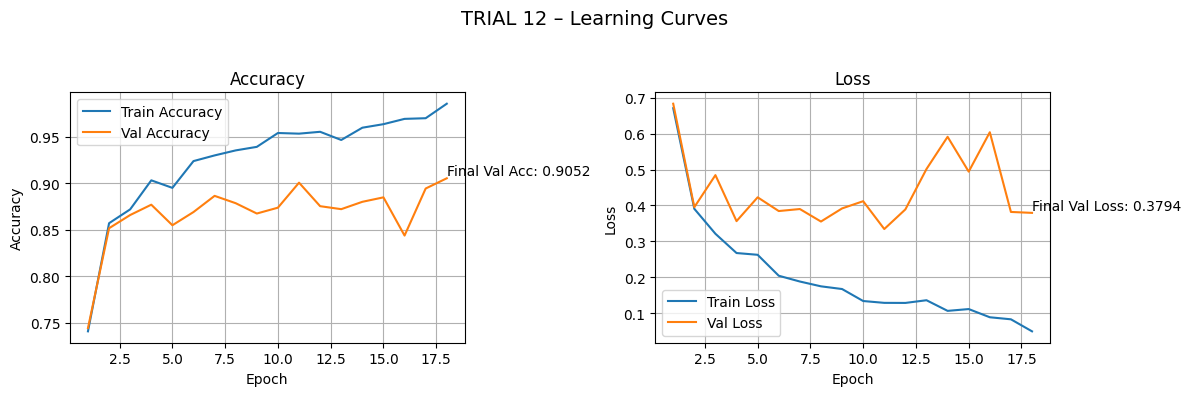


TRIAL 13
Final Train Acc : 0.9522
Final Val Acc   : 0.9036
Final Train Loss: 0.1276
Final Val Loss  : 0.2743


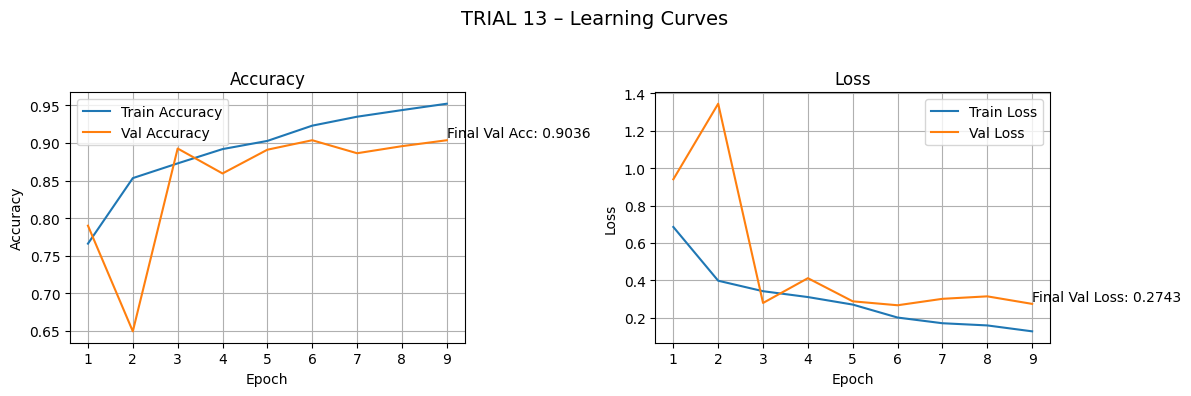


TRIAL 14
Final Train Acc : 0.9844
Final Val Acc   : 0.8910
Final Train Loss: 0.0559
Final Val Loss  : 0.3663


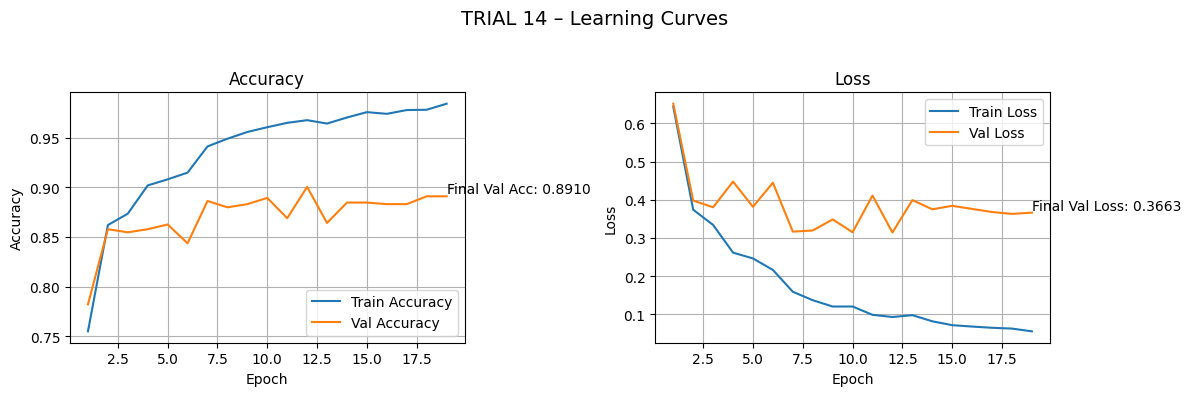


TRIAL 15
Final Train Acc : 0.8043
Final Val Acc   : 0.7883
Final Train Loss: 0.5049
Final Val Loss  : 0.5259


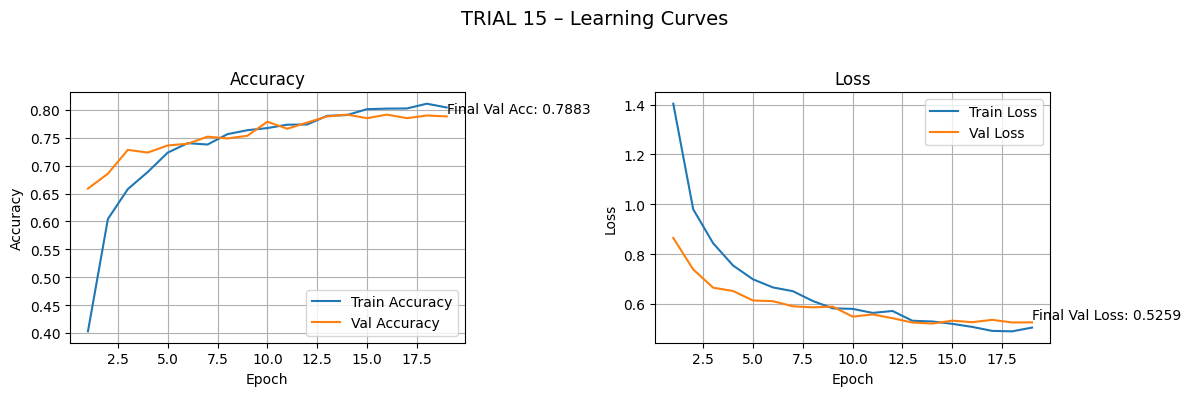

In [6]:
import matplotlib.pyplot as plt
import os

SAVE_PLOTS = True
OUTPUT_DIR = "learning_curves"

if SAVE_PLOTS:
    os.makedirs(OUTPUT_DIR, exist_ok=True)

for trial_data in experiments:
    trial = trial_data["trial"]
    epochs_data = trial_data["epochs"]

    epochs = [e["epoch"] for e in epochs_data]
    acc = [e["accuracy"] for e in epochs_data]
    val_acc = [e["val_accuracy"] for e in epochs_data]
    loss = [e["loss"] for e in epochs_data]
    val_loss = [e["val_loss"] for e in epochs_data]

    # Final values
    final_acc = acc[-1]
    final_val_acc = val_acc[-1]
    final_loss = loss[-1]
    final_val_loss = val_loss[-1]

    # ================= Console Header =================
    print(f"\n====================")
    print(f"TRIAL {trial}")
    print(f"Final Train Acc : {final_acc:.4f}")
    print(f"Final Val Acc   : {final_val_acc:.4f}")
    print(f"Final Train Loss: {final_loss:.4f}")
    print(f"Final Val Loss  : {final_val_loss:.4f}")
    print(f"====================")

    # ================= Plot =================
    plt.figure(figsize=(12, 4))

    # ---- Accuracy subplot (LEFT) ----
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label="Train Accuracy")
    plt.plot(epochs, val_acc, label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy")
    plt.legend()
    plt.grid(True)

    # Annotate final accuracy
    plt.text(
        epochs[-1], final_val_acc,
        f"Final Val Acc: {final_val_acc:.4f}",
        verticalalignment="bottom"
    )

    # ---- Loss subplot (RIGHT) ----
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss")
    plt.legend()
    plt.grid(True)

    # Annotate final loss
    plt.text(
        epochs[-1], final_val_loss,
        f"Final Val Loss: {final_val_loss:.4f}",
        verticalalignment="bottom"
    )

    plt.suptitle(f"TRIAL {trial} – Learning Curves", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    if SAVE_PLOTS:
        plt.savefig(
            os.path.join(OUTPUT_DIR, f"trial_{trial}_learning_curve.png"),
            dpi=300,
            bbox_inches="tight"
        )

    plt.show()



TRIAL 6
LR           : 1e-05
EarlyStopping: 5
LR Patience  : 3
Unfreeze     : unfreeze_50
Final Train Acc : 0.9240
Final Val Acc   : 0.8831
Final Train Loss: 0.2155
Final Val Loss  : 0.3453


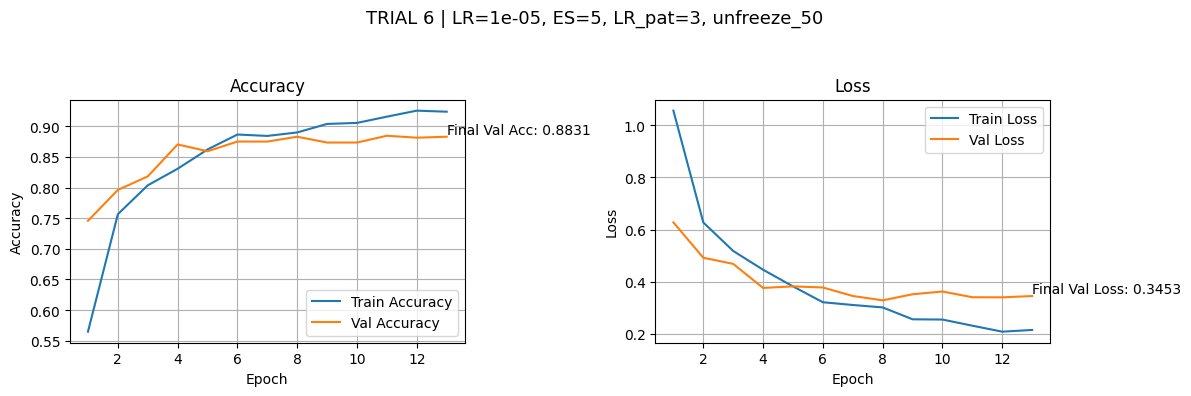


TRIAL 13
LR           : 0.001
EarlyStopping: 3
LR Patience  : 2
Unfreeze     : unfreeze_50
Final Train Acc : 0.9522
Final Val Acc   : 0.9036
Final Train Loss: 0.1276
Final Val Loss  : 0.2743


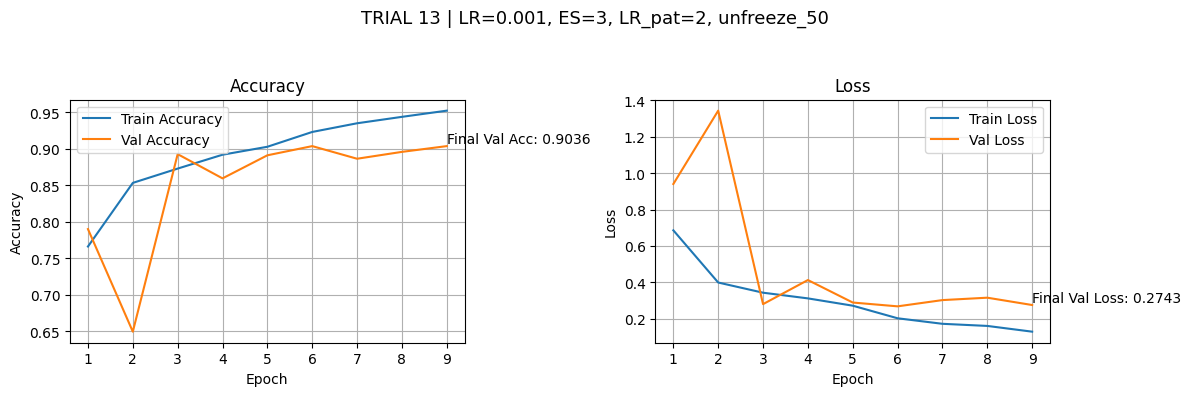


TRIAL 15
LR           : 0.0001
EarlyStopping: 5
LR Patience  : 2
Unfreeze     : freeze_all
Final Train Acc : 0.8043
Final Val Acc   : 0.7883
Final Train Loss: 0.5049
Final Val Loss  : 0.5259


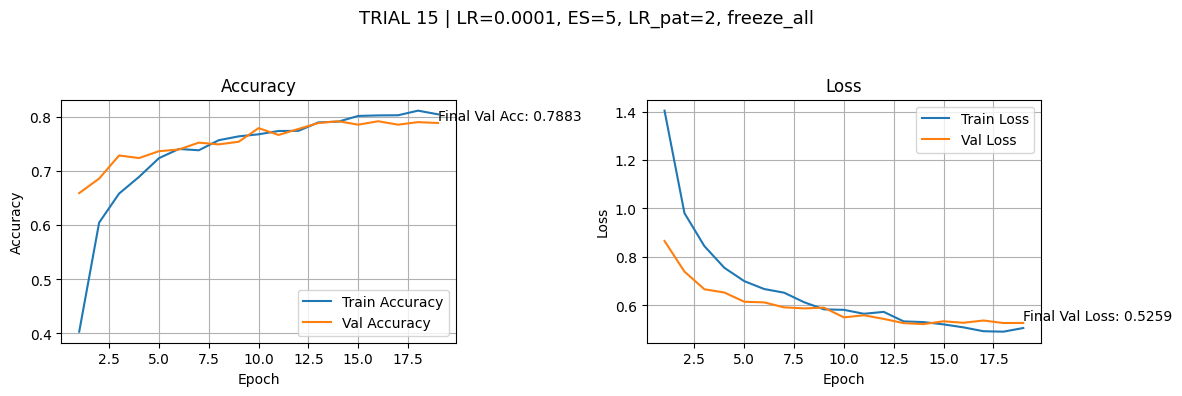

In [9]:
import matplotlib.pyplot as plt
import os

# Trials to show
SELECTED_TRIALS = {6, 13, 15}

SAVE_PLOTS = True
OUTPUT_DIR = "learning_curves_selected"

if SAVE_PLOTS:
    os.makedirs(OUTPUT_DIR, exist_ok=True)

for trial_data in experiments:
    trial = trial_data["trial"]

    if trial not in SELECTED_TRIALS:
        continue

    epochs_data = trial_data["epochs"]
    hp = trial_data.get("hyperparams", {})

    epochs = [e["epoch"] for e in epochs_data]
    acc = [e["accuracy"] for e in epochs_data]
    val_acc = [e["val_accuracy"] for e in epochs_data]
    loss = [e["loss"] for e in epochs_data]
    val_loss = [e["val_loss"] for e in epochs_data]

    # Final values
    final_acc = acc[-1]
    final_val_acc = val_acc[-1]
    final_loss = loss[-1]
    final_val_loss = val_loss[-1]

    # ================= Console Output =================
    print("\n===================================")
    print(f"TRIAL {trial}")
    print(f"LR           : {hp.get('lr')}")
    print(f"EarlyStopping: {hp.get('early_stopping')}")
    print(f"LR Patience  : {hp.get('lr_patience')}")
    print(f"Unfreeze     : {hp.get('unfreeze')}")
    print(f"Final Train Acc : {final_acc:.4f}")
    print(f"Final Val Acc   : {final_val_acc:.4f}")
    print(f"Final Train Loss: {final_loss:.4f}")
    print(f"Final Val Loss  : {final_val_loss:.4f}")
    print("===================================")

    # ================= Plot =================
    plt.figure(figsize=(12, 4))

    # ---- Accuracy (LEFT) ----
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label="Train Accuracy")
    plt.plot(epochs, val_acc, label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.text(
        epochs[-1], final_val_acc,
        f"Final Val Acc: {final_val_acc:.4f}",
        verticalalignment="bottom"
    )

    # ---- Loss (RIGHT) ----
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss")
    plt.legend()
    plt.grid(True)

    plt.text(
        epochs[-1], final_val_loss,
        f"Final Val Loss: {final_val_loss:.4f}",
        verticalalignment="bottom"
    )

    # ---- Figure title with config ----
    plt.suptitle(
        f"TRIAL {trial} | "
        f"LR={hp.get('lr')}, "
        f"ES={hp.get('early_stopping')}, "
        f"LR_pat={hp.get('lr_patience')}, "
        f"{hp.get('unfreeze')}",
        fontsize=13
    )

    plt.tight_layout(rect=[0, 0, 1, 0.93])

    if SAVE_PLOTS:
        plt.savefig(
            os.path.join(OUTPUT_DIR, f"trial_{trial}_comparison.png"),
            dpi=300,
            bbox_inches="tight"
        )

    plt.show()


# Fitting the model

In [62]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=callbacks,
    class_weight=cw
)


Epoch 1/100


2025-12-19 22:32:21.212761: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f17540292d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-19 22:32:21.212802: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-12-19 22:32:21.468785: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-19 22:32:23.169616: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
I0000 00:00:1766158350.654211   57012 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


185/185 ━━━━━━━━━━━━━━━━━━━━ 59s 226ms/step - accuracy: 0.5599 - loss: 1.0959 - val_accuracy: 0.7378 - val_loss: 0.6285 - learning_rate: 1.0000e-05
Epoch 2/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 28s 150ms/step - accuracy: 0.7501 - loss: 0.6525 - val_accuracy: 0.8183 - val_loss: 0.5018 - learning_rate: 1.0000e-05
Epoch 3/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 146ms/step - accuracy: 0.7864 - loss: 0.5383 - val_accuracy: 0.8341 - val_loss: 0.4553 - learning_rate: 1.0000e-05
Epoch 4/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 29s 154ms/step - accuracy: 0.8349 - loss: 0.4455 - val_accuracy: 0.8452 - val_loss: 0.4101 - learning_rate: 1.0000e-05
Epoch 5/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 28s 159ms/step - accuracy: 0.8586 - loss: 0.3855 - val_accuracy: 0.8626 - val_loss: 0.3762 - learning_rate: 1.0000e-05
Epoch 6/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 144ms/step - accuracy: 0.8613 - loss: 0.3509 - val_accuracy: 0.8705 - val_loss: 0.3949 - learning_rate: 1.0000e-05
Epoch 7/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 147ms/s

# Learning Curve of the model

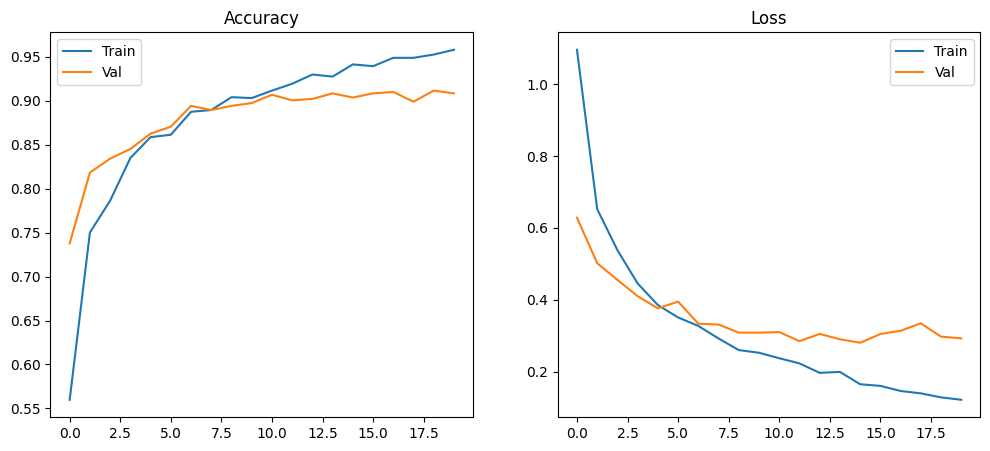

Best Epoch            : 15
Best Train Loss       : 0.1649
Best Validation Loss  : 0.2804
Best Train Accuracy   : 0.9413
Best Validation Acc   : 0.9036
Final Validation Acc  : 0.9084


In [71]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(["Train", "Val"])

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.legend(["Train", "Val"])

plt.show()

best_epoch = min(
    range(len(history.history['val_loss'])),
    key=lambda i: history.history['val_loss'][i]
)

best_train_loss = history.history['loss'][best_epoch]
best_val_loss = history.history['val_loss'][best_epoch]
best_train_acc = history.history['accuracy'][best_epoch]
best_val_acc = history.history['val_accuracy'][best_epoch]

print(f"Best Epoch            : {best_epoch + 1}")
print(f"Best Train Loss       : {best_train_loss:.4f}")
print(f"Best Validation Loss  : {best_val_loss:.4f}")
print(f"Best Train Accuracy   : {best_train_acc:.4f}")
print(f"Best Validation Acc   : {best_val_acc:.4f}")

print(f"Final Validation Acc  : {final_val_acc:.4f}")


# Test Evaluation
## Accuracy

In [64]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.8945 - loss: 0.2917
Test Accuracy: 0.8944882154464722


## Inference on the test set

In [ ]:
import numpy as np

# Get ground-truth labels
y_true = test_generator.classes

# Predict probabilities
y_pred_prob = model.predict(test_generator)

# Convert to predicted class indices
y_pred = np.argmax(y_pred_prob, axis=1)

# Class labels (in correct order)
class_names = list(test_generator.class_indices.keys())
print("Class order:", class_names)


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step
Class order: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


## Confusion matrix

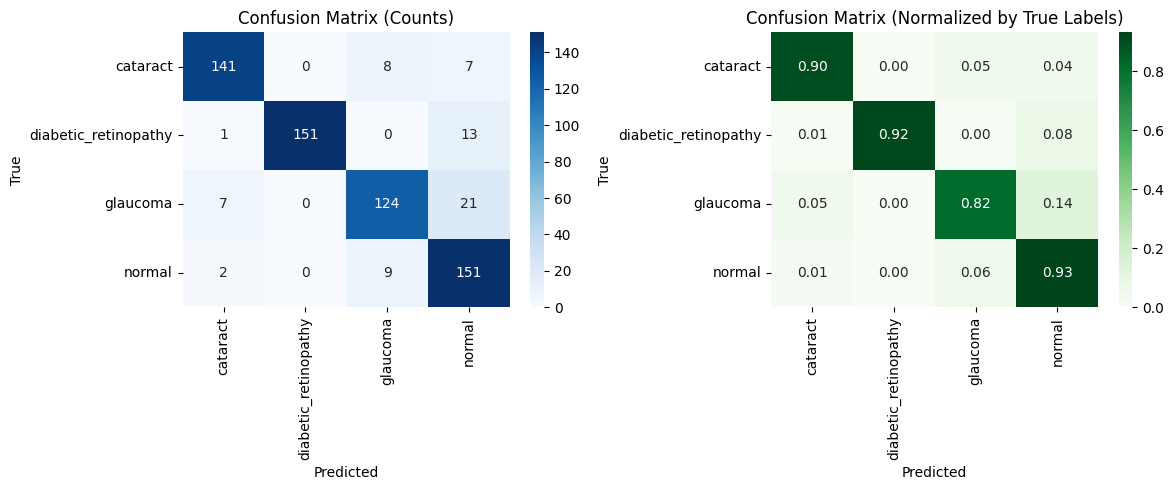

In [111]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
cm_normalized = confusion_matrix(y_true, y_pred, normalize='true')

plt.figure(figsize=(12,5))

# Raw confusion matrix
plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Counts)")
plt.xlabel("Predicted")
plt.ylabel("True")

# Normalized confusion matrix
plt.subplot(1,2,2)
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Greens", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Normalized by True Labels)")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.tight_layout()
plt.show()


In [102]:
glaucoma_idx = test_generator.class_indices["glaucoma"]
normal_idx = test_generator.class_indices["normal"]

print("glaucoma index:", glaucoma_idx)
print("normal index:", normal_idx)


glaucoma index: 2
normal index: 3


In [103]:
import numpy as np

misclassified_idx = np.where(
    (y_true == glaucoma_idx) & (y_pred == normal_idx)
)[0]

print(f"Total glaucoma → normal mislabels: {len(misclassified_idx)}")


Total glaucoma → normal mislabels: 21


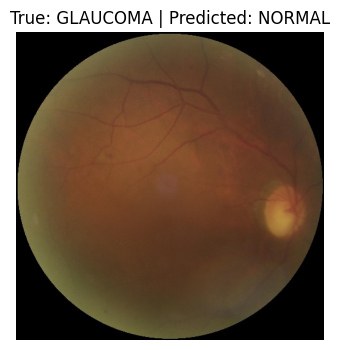

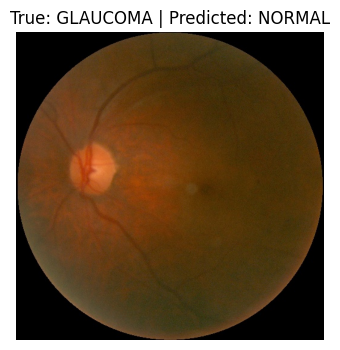

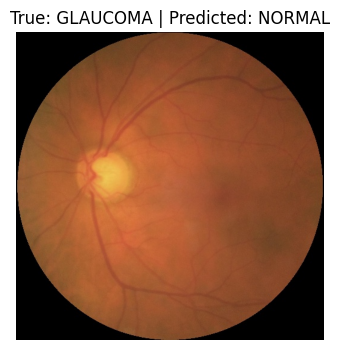

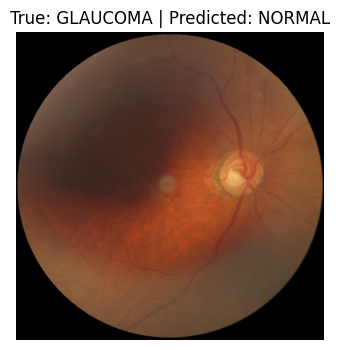

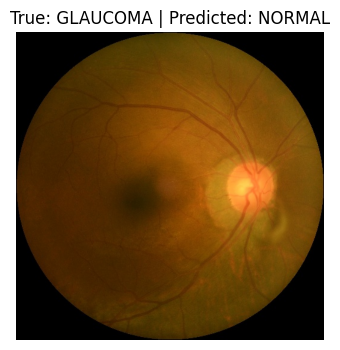

In [105]:
from PIL import Image
import matplotlib.pyplot as plt

N_SHOW = 5  # number of samples to visualize

for i, img_index in enumerate(misclassified_idx[:N_SHOW]):
    filepath = test_generator.filepaths[img_index]

    img = Image.open(filepath).convert("RGB")

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.title("True: GLAUCOMA | Predicted: NORMAL")
    plt.axis("off")
    plt.show()


## F1 Score

In [106]:
from sklearn.metrics import f1_score

f1_micro = f1_score(y_true, y_pred, average='micro')
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("F1 Micro:     ", round(f1_micro, 4))
print("F1 Macro:     ", round(f1_macro, 4))
print("F1 Weighted:  ", round(f1_weighted, 4))


F1 Micro:      0.8929
F1 Macro:      0.8934
F1 Weighted:   0.8942


## Summary of F1 Score

In [107]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_names))


                      precision    recall  f1-score   support

            cataract       0.93      0.90      0.92       156
diabetic_retinopathy       1.00      0.92      0.96       165
            glaucoma       0.88      0.82      0.85       152
              normal       0.79      0.93      0.85       162

            accuracy                           0.89       635
           macro avg       0.90      0.89      0.89       635
        weighted avg       0.90      0.89      0.89       635



In [98]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_train = train_generator.classes

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
print(class_weights)


{0: np.float64(1.015495867768595), 1: np.float64(0.9599609375), 2: np.float64(1.0472301136363635), 3: np.float64(0.9816910785619174)}


In [99]:
glaucoma_idx = test_generator.class_indices["glaucoma"]
